Machine Learning Series
===================


-----

#1 - Install **sklearn** and **quandl**
======

- pip install sklearn 

- pip install quandl

- When using Jupyter Notebook use the following terminal entry "**conda install -c https://conda.anaconda.org/anaconda quandl**"

- Make sure "**urllib3**" is installed as well!

In [1]:
import sklearn as sk
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

In [2]:
style.use('ggplot')

**Make sure to insert API key below! You can get one by creating an account on www.quandl.com**

*If you upload your Notebook to any public place make sure you **delete** your API key!!!*

In [3]:
quandl.ApiConfig.api_key = "bsPqzouaLS1qBLUMqk2M"
df = quandl.get('WIKI/GOOGL') #quandl.get returns a dataframe!

In [4]:
#%%capture #suppress output
print(df)

                Open     High      Low     Close      Volume  Ex-Dividend  \
Date                                                                        
2004-08-19   100.010   104.06    95.96   100.335  44659000.0          0.0   
2004-08-20   101.010   109.08   100.50   108.310  22834300.0          0.0   
2004-08-23   110.760   113.48   109.05   109.400  18256100.0          0.0   
2004-08-24   111.240   111.60   103.57   104.870  15247300.0          0.0   
2004-08-25   104.760   108.00   103.88   106.000   9188600.0          0.0   
2004-08-26   104.950   107.95   104.66   107.910   7094800.0          0.0   
2004-08-27   108.100   108.62   105.69   106.150   6211700.0          0.0   
2004-08-30   105.280   105.49   102.01   102.010   5196700.0          0.0   
2004-08-31   102.320   103.71   102.16   102.370   4917800.0          0.0   
2004-09-01   102.700   102.97    99.67   100.250   9138200.0          0.0   
2004-09-02    99.090   102.37    98.94   101.510  15118600.0          0.0   

**Difference between "Adj. High" and "Adj. Low" (margin) for instance tells us something about the volatility**

**Difference between "Adj. Open" and "Adj. Close" tells us by how much the price changed during the day**

--> Valuable relationship - however **linear regression** is not going to seek out this.

-----

What we need to do is to define special relationships and then define those as our features rather than using redundant prices that do not give us anything useful.

In [5]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume',]]

**Define new column for the high minus low - something like the percent volatility.**

In [6]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100.0

**Does not matter if times 100 or not - classifier does not really care (as long as it is normalized)!**

------

**Now let's define the daily change.**

In [7]:
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

**Now we define columns we really care about**

In [8]:
df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]

In [9]:
print(df.head()) # Dataframe.head(n=5) - this method is used to return top n (5 by default) rows of df or series

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.441017    0.324968   44659000.0
2004-08-20   54.322689  8.537313    7.227007   22834300.0
2004-08-23   54.869377  4.062357   -1.227880   18256100.0
2004-08-24   52.597363  7.753210   -5.726357   15247300.0
2004-08-25   53.164113  3.966115    1.183658    9188600.0


**"Adj. Close" highly dependent on "HL_PCT" and "PCT_change" which would be a highly biased classifier - so predicting with "Adj. Close" would not really make sense. But what we will do here is to take the last let's say 10 values of "Adj. Close" and define that as a feature trying to predict the future value.**

------

#2 - Regression Features and Labels
======

In [10]:
forecast_col = 'Adj. Close'

**In order to replace NaN data you have to put something back in. Usually deleting columns is not a good idea!**
**We usually miss data in the real world and want to avoid deleting a whole column!**

In [11]:
df.fillna(-99999, inplace=True)

**In pandas, when the data in a column/row is not available, it's labelled NaN(not a number). dropna() removes these "cells" and "inplace=True" means change it in the dataset and not just the copy of the dataset.**

In [12]:
forecast_out = int(math.ceil(0.01*len(df))) # round everything up to the nearest whole / do not forget to import math

**We are taking 0.01 or 1% of the length of all the rows within the dataframe. Each row in the dataFrame is representative of a day in the life of the stock. So if the stock has been trading for 365 days, there will be 365 rows in the dataFrame. 1% of 365 is 3.65 days which is then rounded up by the math.ceil function to 4 days. The 4 days will be the "forecast_out" variable which is the variable that used to shift the "Adj.Close" price column in the dataFame up by 4. In other words, if you were standing at day 1 of the stock when it was first traded, the prediction or the "label" from his algorithm would tell you that at day 4, your stock will be valued at the amount of the close as taken on day 4 from actual data. This isn't totally useful information since you can look at the Adj.Close column on day 4 to get back to the label info on day 1. This is really all done to build a training set so that the machine can learn from the trend.**


----

**We can also test later what the difference between "Adj. Close" and "label" is and when using 10% the difference is much bigger between those two than using 1%. I assume that this is just related to the fact that in a short amount of time the prices changed so drastically before they "stabilized" a bit later.**

In [13]:
#print(forecast_out)

**Now we are renaming the column so that if you would use this sheet as a template you do not have to adapt every single line seperately. We also shift the forecast column up. This way the label column for each row will be the "Adj. Close" price 10 days into the future**

In [14]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [15]:
# print(df.head())
#print(df.tail())
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  8.441017    0.324968   44659000.0  69.078238
2004-08-20   54.322689  8.537313    7.227007   22834300.0  67.839414
2004-08-23   54.869377  4.062357   -1.227880   18256100.0  68.912727
2004-08-24   52.597363  7.753210   -5.726357   15247300.0  70.668146
2004-08-25   53.164113  3.966115    1.183658    9188600.0  71.219849


**First we fill the NaN values with -99999, then after we shift the value, the tail end will have NaN values.
Instead of Replacing them with -99999 we drop them. You might think why we did not drop them in the first place. Because In the dataset one or the other row had NaN so if it would be deleted, the dataset would have reduced drastically!!! But in the next we can drop them as only 33 rows will be droped. Why 33? Because it is 1% (0.01) of the hole data set. So the loss in Data was minimal.**

------

#3 - Training and Testing
======

**Features are everything except label column. df.drop returns a new dataframe which is being converted to a numpy array and saved to X (independent variables). Y is our dependent variable!**

In [16]:
X = np.array(df.drop(['label'],1))

**Before shooting through the classifier we have to scale X!**

- **Scale if you want to optimize the accuracy of your model predictions.**
- **Do not scale if you want to keep the most interpretation as possible in your model.**

In [17]:
X = preprocessing.scale(X)

In [18]:
X_lately = X[-forecast_out:] # that's what we predict against! Extracting last entry of X

In [19]:
X = X[:-forecast_out:]

In [20]:
df.dropna(inplace=True)

In [21]:
y = np.array(df['label'])

**What is the difference between the training set and the test set?**
-----
**The training set is a subset of your data on which your model will learn how to predict the dependent variable with the independent variables. The test set is the complimentary subset from the training set, on which you will evaluate your model to see if it manages to predict correctly the dependent variable with the independent variables.**


-----

- **Training Set:** *The sample of data used to fit the model*. The actual dataset that we use to train the model (weights and biases in the case of Neural Network). The model sees and learns from this data.
----
- **Validation Set:** *The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration*. The validation set is used to evaluate a given model, but this is for frequent evaluation.
-----
- **Test Set:** *The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.* The Test dataset provides the gold standard used to evaluate the model. It is only used once a model is completely trained (using the train and validation sets). The test set is generally what is used to evaluate competing models (For example on many Kaggle competitions, the validation set is released initially along with the training set and the actual test set is only released when the competition is about to close, and it is the result of the model on the Test set that decides the winner). Many a times the validation set is used as the test set, but it is not good practice. The test set is generally well curated. It contains carefully sampled data that spans the various classes that the model would face, when used in the real world.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # deleted "random_state = 0"

**Define the regressor now!**

In [23]:
#clf = LinearRegression()

In [24]:
# clf = svm.SVR() # performs a lot worse than Linear Regression!

In [25]:
#clf.fit(X_train, y_train) # training step

**By creating a so called pickle we do not have to always train our classifier which is kind of useless in this case but sometimes the training can take up Gigabytes which would be an inefficient task to do thus the pickle trick.**

In [26]:
#with open('linearregression.pickle', 'wb') as f: # with "with open..." the close() function will be autom. called
 #   pickle.dump(clf, f)

In [27]:
pickle_in = open('linearregression.pickle', 'rb')

**Once run you can comment out:**

- clf = LinearRegression()

- clf.fit(X_train, y_train)

- with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [28]:
clf = pickle.load(pickle_in) 

In [29]:
accuracy = clf.score(X_test, y_test)

In [30]:
print(accuracy) # this is the squared error!

0.97703396571


------

#4 - Forecasting and Predicting
======

In [31]:
forecast_set = clf.predict(X_lately)

In [32]:
print(forecast_set, accuracy, forecast_out) # forecast_out shows us the next 35 days of prices

[ 1097.3585024   1070.74036716  1016.2129631   1055.45226624  1071.68416056
  1072.47341686  1089.78880161  1108.40689682  1113.76956196  1120.96217446
  1130.75596015  1127.89455085  1146.50393287  1162.91346796  1134.28465635
  1120.89387017  1085.2099126   1099.85734743  1111.83153911  1120.10875412
  1132.69304114  1148.53948905  1178.73386253  1184.53807383  1154.93392242
  1167.57687008  1168.27656636  1151.50875155  1116.06467225  1112.96968501
  1111.64807517  1067.90882966  1040.32166404  1067.24158995  1016.41100922] 0.97703396571 35


**Date is not a feature so we have to do some work to get something we can actually plot.**

In [33]:
df['Forecast'] = np.nan

**".iloc" works based on integer positioning. So no matter what our row labels are, we can always, e.g., get the first row by doing df.iloc[0]**

-----

**.loc selects data only by labels!** --> Good explanation here **https://stackoverflow.com/questions/31593201/how-are-pandas-iloc-ix-and-loc-different-and-related**

In [34]:
last_date = df.iloc[-1].name

In [35]:
print(df.iloc[-1].name)

2018-02-05 00:00:00


In [36]:
last_unix = last_date.timestamp()

In [37]:
one_day = 86400

In [38]:
next_unix = last_unix + one_day

In [39]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range (len(df.columns)-1)] + [i]

**To see what this for loop does simply print the tail to get a rough idea**

In [40]:
print(df.tail())

            Adj. Close  HL_PCT  PCT_change  Adj. Volume  label     Forecast
Date                                                                       
2018-03-08         NaN     NaN         NaN          NaN    NaN  1111.648075
2018-03-09         NaN     NaN         NaN          NaN    NaN  1067.908830
2018-03-10         NaN     NaN         NaN          NaN    NaN  1040.321664
2018-03-11         NaN     NaN         NaN          NaN    NaN  1067.241590
2018-03-12         NaN     NaN         NaN          NaN    NaN  1016.411009


<function matplotlib.pyplot.show>

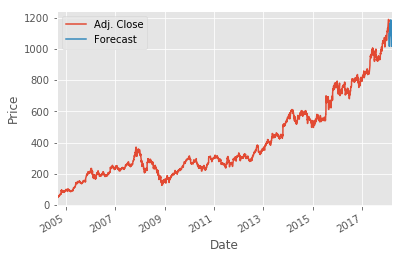

In [41]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=0)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show

------

#5 - Pickling and Scaling
======

- for that we imported **pickle** at the top

------

#6 - How Regression works
======

Please visit the following page for a rough explanation of regression.

------

#7 - How to program Best Fit Slope
======